In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

# Define the years to import
yrs = range(2017, 2020)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

2017 done.
2018 done.
2019 done.
Downcasting floats.


# Feature Engineering

In [22]:
def feature_engineering(pbp_data):
    # 1. Define data
    df = pbp_data[['play_type', 'offense_formation',  'defenders_in_box', 'ydstogo', 'half_seconds_remaining', 'wp', 'ep', 'week', 'down', 'run_gap',
            'defense_personnel', 'offense_personnel', 'number_of_pass_rushers', 'defense_man_zone_type', 'defense_coverage_type', 'yardline_100', 'xpass', 'play_clock',
            'temp', 'wind', 'roof', 'surface', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'shotgun', 'no_huddle', 'home_team', 'posteam', 'defteam',
            'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'score_differential', 'qtr', 'drive', 
            'game_id', 'play_id', 'epa', 'yards_gained']].sort_values(['game_id', 'play_id']).copy()

    df = df[df['play_type'].isin(['run','pass'])]

    standard_cols = ['play_type', 'defenders_in_box', 'number_of_pass_rushers', 'ydstogo', 'half_seconds_remaining', 'wp', 'ep', 'week', 'down',
            'yardline_100', 'xpass', 'score_differential', 'qtr', 'drive', 'temp']
    original_standard_cols = standard_cols.copy() # Store the original standard_cols that include categorical variables

    # 2. Personnel counts
    df['rb_count'] = df['offense_personnel'].str.extract(r'(\d+)\s*RB').astype(float)
    df['wr_count'] = df['offense_personnel'].str.extract(r'(\d+)\s*WR').astype(float)
    df['te_count'] = df['offense_personnel'].str.extract(r'(\d+)\s*TE').astype(float)
    df['db_count'] = df['defense_personnel'].str.extract(r'(\d+)\s*DB').astype(float)
    df['lb_count'] = df['defense_personnel'].str.extract(r'(\d+)\s*LB').astype(float)
    df['dl_count'] = df['defense_personnel'].str.extract(r'(\d+)\s*DL').astype(float)
    df['wr_db_diff'] = df['wr_count'] - df['db_count']
    df['rb_lb_diff'] = df['rb_count'] - df['lb_count']
    df['number_of_pass_rushers'] = df['number_of_pass_rushers'].fillna(4)
    df['blockers'] = 5 + df['te_count'] + df['rb_count']  # 5 OL + TEs + RBs (approximate)
    df['pressure_ratio'] = df['number_of_pass_rushers'] / (df['blockers'] + 1e-6)
    df['box_minus_rushers'] = df['defenders_in_box'] - df['number_of_pass_rushers']
    df['box_advantage'] = df['box_minus_rushers'] / (df['number_of_pass_rushers'] + 1e-6)
    df['defensive_back_density'] = df['db_count'] / (df['defenders_in_box'] + 1e-6)
    df['front_density'] = (df['dl_count'] + df['lb_count']) / (df['defenders_in_box'] + 1e-6)
    df['receiver_db_ratio'] = df['wr_count'] / (df['db_count'] + 1e-6)
    df['xpass_receivers'] = (df['wr_count'] + df['te_count']) * df['xpass']
    df['skill_vs_coverage'] = (df['rb_count'] + df['wr_count'] + df['te_count']) / (df['lb_count'] + df['db_count'] + 1e-6) # Offensive skill mismatch vs. back 7 defenders (LBs + DBs)
    df['box_skill_pressure'] = df['defenders_in_box'] / (df['rb_count'] + df['wr_count'] + 1e-6) # Box crowding adjusted by skill players
    df['coverage_complexity'] = df['db_count'] / (df['lb_count'] + 1e-6) # Ratio of DBs to LBs: cover vs. run balance
    df['blitz_indicator'] = df['number_of_pass_rushers'] - df['dl_count']  # If >0, someone else is rushing
    df['rush_position_diversity'] = (df['lb_count'] + df['db_count']) / (df['dl_count'] + 1e-6) # Defensive front composition (blitz potential)
    df['skill_players_total'] = df['rb_count'] + df['wr_count'] + df['te_count'] # Skill player load: How many skill players are deployed
    df['receiver_blocker_balance'] = (df['wr_count'] + df['te_count']) / (df['rb_count'] + df['te_count'] + 5)  # 5 OL # Receiver loading vs. protection
    df['blocker_to_rusher_ratio'] = df['blockers'] / (df['number_of_pass_rushers'] + 1e-6) # Committed blockers per rusher
    df['pass_block_stress'] = df['number_of_pass_rushers'] - df['blockers'] # Mismatch between blockers and pass rushers
    df['pass_advantage'] = (df['wr_count'] + df['te_count']) - df['db_count'] # WR leverage vs. DBs
    df['defensive_front_leverage'] = df['dl_count'] - df['te_count'] # Defensive line tilt
    df['pressure_on_late_downs'] = df['pressure_ratio'] * (df['down'] >= 3).astype(int) # Down-weighted pressure (more likely to pass under pressure)
    df['o_formation_reuse'] = (df.groupby(['game_id', 'offense_formation']).cumcount())  # How often the offense uses this formation
    df['d_coverage_reuse'] = (df.groupby(['game_id', 'defense_coverage_type']).cumcount())  # How often the defense uses this coverage

    personnel_cols = ['rb_count', 'wr_count', 'te_count', 'db_count', 'lb_count', 'dl_count',
                    'box_minus_rushers', 'box_advantage', 'defensive_back_density', 'receiver_db_ratio', 'xpass_receivers',
                    'front_density', 'pressure_ratio', 'blockers', 'wr_db_diff', 'rb_lb_diff', 'skill_vs_coverage',
                    'box_skill_pressure', 'coverage_complexity', 'blitz_indicator', 'rush_position_diversity',
                    'receiver_blocker_balance', 'blocker_to_rusher_ratio',
                    'pass_advantage', 'defensive_front_leverage', 'pressure_on_late_downs', 'o_formation_reuse', 'd_coverage_reuse'
                    ]

    # 3. Core features
    df['log_ydstogo'] = np.log1p(df['ydstogo'])
    df['log_yardline'] = np.log1p(df['yardline_100'])
    df['garbage_time'] = ((df['wp'] <= 0.10) | (df['wp'] >= 0.90)).astype(int)
    df['two_min_warn'] = (df['half_seconds_remaining'] <= 120).astype(int)
    df['win_formation'] = ((df['wp'] >= 0.75).astype(int) & (df['half_seconds_remaining'] <= 120).astype(int))
    df['dist_down'] = df['down'] * df['ydstogo']
    df['home_field'] = (df['posteam'] == df['home_team']).astype(int)
    df['timeout_diff'] = df['posteam_timeouts_remaining'] - df['defteam_timeouts_remaining']
    df['yardline_wp'] = df['yardline_100'] * df['wp']
    df['score_diff_qtr'] = df['score_differential'] * df['qtr']
    df['score_diff_drive'] = df['score_differential'] * df['drive']
    df['epa_leverage'] = df['wp'] * (100 - df['yardline_100']) / 100
    df['critical_down'] = ((df['down'] >= 3) & (df['ydstogo'] > 5)).astype(int)
    df['crunch_time'] = ((df['qtr'] == 4) & (df['wp'] <= 0.33)).astype(int)
    df['prev_yards_gain'] = df.groupby('game_id')['yards_gained'].shift(1)
    df['overreaction'] = (df['prev_yards_gain'] >= 10).astype(int)
    df['soft_defense'] = ((df['score_differential'] >= 7) & (df['yardline_100'] >= 45) & (df['half_seconds_remaining'] <= 120)).astype(int)
    df['yardline_per_sec'] = df['yardline_100'] / (df['half_seconds_remaining'] + 1e-6)  # Yardline per second
    df['rolling_pass_plays'] = df.groupby('game_id')['play_type'].transform(lambda x: (x == 'pass').rolling(window=3, min_periods=1).sum())

    core_cols = ['log_ydstogo', 'log_yardline', 'garbage_time', 'two_min_warn',
                'win_formation', 'dist_down', 'home_field', 'timeout_diff', 'yardline_wp', 
                'score_diff_qtr', 'score_diff_drive', 'epa_leverage', 'critical_down',
                'crunch_time', 'overreaction', 'prev_yards_gain', 'soft_defense', 'yardline_per_sec', 'rolling_pass_plays'
                ]

    df = df.drop(columns=['home_team', 'posteam', 'defteam', 'offense_personnel', 'defense_personnel'], axis=1)

    # Step 4.1: Define categorical columns before dummy expansion
    categorical_columns_raw = ['play_type', 'offense_formation', 'run_gap', 'defense_man_zone_type',
                            'defense_coverage_type', 'roof', 'surface']

    # Step 4.2: One-hot encode and collect dummy column names
    dummy_col_mapping = {}
    for col in categorical_columns_raw:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        dummy_col_mapping[col] = list(dummies.columns)
        df = pd.concat([df, dummies], axis=1)

    # Remove original categorical columns
    df.drop(columns=categorical_columns_raw, inplace=True)

    # Step 4.3: Define the new categorical_cols group
    categorical_cols = []
    for col in categorical_columns_raw:
        categorical_cols.extend(dummy_col_mapping[col])  # All generated dummy columns

    # Step 5: Rebuild standard_cols (numerical/binary columns only)
    standard_cols = []
    for col in original_standard_cols:
        if col not in categorical_columns_raw and col in df.columns:
            standard_cols.append(col)

    # Sanity check: Ensure no overlap
    assert len(set(standard_cols).intersection(categorical_cols)) == 0

    return df, categorical_cols, standard_cols, core_cols, personnel_cols

df, categorical_cols, standard_cols, core_cols, personnel_cols = feature_engineering(pbp_data)
df.head()

,defenders_in_box,ydstogo,half_seconds_remaining,wp,ep,week,down,number_of_pass_rushers,yardline_100,xpass,...,roof_open,roof_outdoors,surface_a_turf,surface_astroplay,surface_astroturf,surface_fieldturf,surface_grass,surface_grass,surface_matrixturf,surface_sportturf
2,NaN,10.0,1800.0,0.422024,0.239785,1,1.0,4.0,80.0,0.456481,...,0,1,0,0,0,0,1,0,0,0
3,NaN,7.0,1773.0,0.420599,-0.097354,1,2.0,4.0,77.0,0.545905,...,0,1,0,0,0,0,1,0,0,0
4,NaN,5.0,1732.0,0.403295,-0.359835,1,3.0,4.0,75.0,0.968533,...,0,1,0,0,0,0,1,0,0,0
5,NaN,10.0,1694.0,0.448653,1.301407,1,1.0,4.0,65.0,0.448571,...,0,1,0,0,0,0,1,0,0,0
6,NaN,10.0,1650.0,0.430587,0.782476,1,2.0,4.0,65.0,0.489852,...,0,1,0,0,0,0,1,0,0,0


In [3]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Example: your raw features and target
X = df.drop(columns=['epa', 'game_id', 'play_id', 'yards_gained']).copy()
y = df['epa'].copy()

# Create fold splits
kf = KFold(n_splits=2, shuffle=True, random_state=99)

# Store fold indices for later reuse
folds = []
for train_idx, test_idx in kf.split(X):
    folds.append((train_idx, test_idx))

scaler = StandardScaler()
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Remove infinities and NaNs
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# ----------------

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Target encoding
group_collection = ['down', 'play_type_run', 'defense_coverage_type_COVER_1', 'defense_coverage_type_COVER_0', 'defense_man_zone_type_ZONE_COVERAGE', 'offense_formation_SINGLEBACK', 
                  'offense_formation_SHOTGUN', 'd_coverage_reuse']

# Build group means on training data only
group_means = df.iloc[train_idx].groupby(group_collection)['epa'].std().reset_index()
group_means = group_means.rename(columns={'epa': 'variance_encoder'})

# Merge into train
X_train = X_train.merge(
    group_means, 
    on=group_collection, 
    how='left'
)

# Merge into test
X_test = X_test.merge(
    group_means, 
    on=group_collection, 
    how='left'
)

# Fill NaNs with 0 after merging
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

cols_collection = ['variance_encoder', 'ydstogo', 'down', 'log_yardline', 'epa_leverage', 'score_diff_drive', 'yardline_wp']

base_model = Ridge(alpha=1.0, fit_intercept=True, max_iter=2000, tol=1e-6)
base_model.fit(X_train[cols_collection], y_train)
y_pred = base_model.predict(X_test[cols_collection])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Base Model MSE: {mse:.4f}, R^2: {r2:.4f}")

# Coeficients
coef_df = pd.DataFrame(base_model.coef_, index=X_train[cols_collection].columns, columns=['Coefficient'])
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df.head(10))  # Display top 10 features by coefficient

# ------------

# Apply to scaled data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled = X_train_scaled.fillna(0)
X_test_scaled = X_test_scaled.fillna(0)

X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Base Model MSE: 1.9290, R^2: 0.0112
                  Coefficient
variance_encoder     0.164859
epa_leverage         0.082665
log_yardline         0.027586
yardline_wp          0.000381
score_diff_drive     0.000029
ydstogo             -0.015423
down                -0.086289


In [4]:
# Check for NaN or infinite values in X_train_scaled
print("NaN in X_train_scaled:", X_train_scaled.isna().sum().sum())
print("Inf in X_train_scaled:", np.isinf(X_train_scaled.values).sum())

# Show columns with NaN or inf
print("Columns with NaN:", X_train_scaled.columns[X_train_scaled.isna().any()].tolist())
print("Columns with Inf:", X_train_scaled.columns[np.isinf(X_train_scaled).any()].tolist())

# Show rows with NaN or inf
nan_rows = X_train_scaled[X_train_scaled.isna().any(axis=1)]
inf_rows = X_train_scaled[np.isinf(X_train_scaled).any(axis=1)]
print("Rows with NaN:", nan_rows.index.tolist())
print("Rows with Inf:", inf_rows.index.tolist())

# Repeat for y_train if needed
print("NaN in y_train:", pd.isna(y_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train_scaled: 0
Inf in X_train_scaled: 0
Columns with NaN: []
Columns with Inf: []
Rows with NaN: []
Rows with Inf: []
NaN in y_train: 0
Inf in y_train: 0


# Practice Modeling

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

def base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, fold_id, label):
    """
    Fit regression on a feature group, predict, and print metrics.
    Returns predictions.
    """
    base_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.02, max_depth=10, reg_lambda=5000.0, gamma=0.50)
    #base_model = Ridge(alpha=1.0)
    base_model.fit(X_train_scaled[feature_cols], y_train)
    preds = base_model.predict(X_test_scaled[feature_cols])
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)    
    train_preds = base_model.predict(X_train_scaled[feature_cols])
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} {label} Base       Test MSE: {mse:.3f}, Test R^2: {r2:.3f} | Train MSE: {train_mse:.3f}, Train R^2: {train_r2:.3f}")
    return pd.DataFrame(train_preds, columns=[label+'_predictions'], index=X_train_scaled.index), pd.DataFrame(preds, columns=[label+'_predictions'], index=X_test_scaled.index), base_model

In [6]:
# Define testing cols
cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols

# Run base evaluation for personnel features
train_preds, test_preds, base_model = base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, cols, 0, "base")

Fold 0 base Base       Test MSE: 1.844, Test R^2: 0.055 | Train MSE: 1.528, Train R^2: 0.204


c:\Users\Jack\Documents\GitHub\FFInsights\code\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


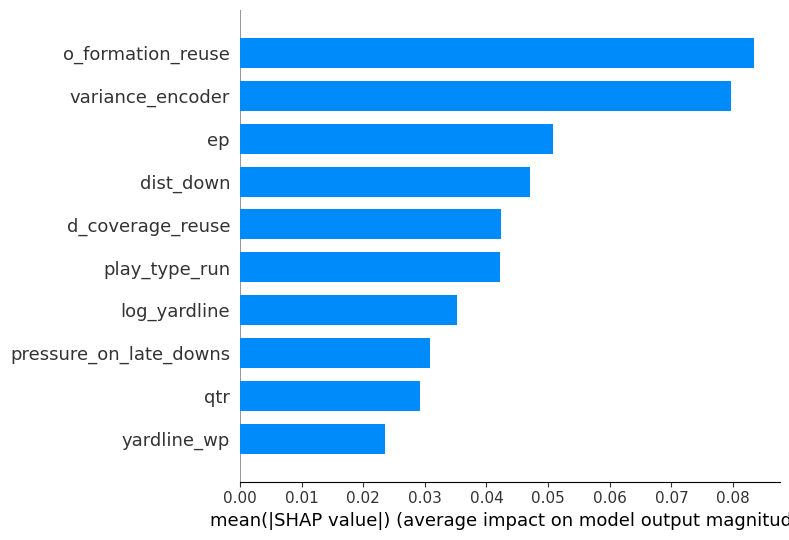

In [7]:
import shap
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_test_scaled[cols])

# Plot SHAP values
shap.summary_plot(shap_values, features=X_test_scaled[cols], feature_names=cols, plot_type='bar', max_display=10)

In [8]:
# Highest shap values
highest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
num_features_to_show = 15  # Change this to show more features
highest_shap_features = [cols[i] for i in highest_shap_indices[:num_features_to_show]]
print("Highest SHAP features:", highest_shap_features)

lowest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[:num_features_to_show]
lowest_shap_features = [cols[i] for i in lowest_shap_indices]
print("Lowest SHAP features:", lowest_shap_features)

Highest SHAP features: ['o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']
Lowest SHAP features: ['yardline_100', 'ydstogo', 'critical_down', 'defense_coverage_type_PREVENT', 'soft_defense', 'two_min_warn', 'defense_coverage_type_COVER_0', 'win_formation', 'wr_count', 'surface_matrixturf', 'roof_open', 'defense_coverage_type_COVER_4', 'rb_count', 'blocker_to_rusher_ratio', 'defense_coverage_type_COVER_6']


In [9]:
def dbscan_fold_eval(X, train_idx, y_train, y_test, col_collection, eps=None, min_samples=None):
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.linear_model import Ridge
    from sklearn.decomposition import PCA
    from sklearn.cluster import DBSCAN
    import pandas as pd
    import numpy as np

    X_cluster = X[col_collection].fillna(0).values

    # DBSCAN parameters
    if min_samples is None:
        min_samples = int(round(len(train_idx) * 0.025, 0))
    if eps is None:
        eps = X_cluster.shape[1] * 0.15
    print(f"DBSCAN parameters - eps: {eps}, min_samples: {min_samples}")

    # Fit DBSCAN on training set
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X_cluster[train_idx])  # Fit only on training data

    # Assign clusters for train and test
    X_train_dbscan = dbscan.fit_predict(X_cluster[train_idx])
    X_test_dbscan = dbscan.fit_predict(X_cluster[[i for i in range(len(X_cluster)) if i not in train_idx]])

    # Convert to DataFrame
    X_train_dbscan = pd.DataFrame(X_train_dbscan, columns=['dbscan_cluster'])
    X_test_dbscan = pd.DataFrame(X_test_dbscan, columns=['dbscan_cluster'])

    # Ridge regression using cluster label as feature
    ridge_model_dbscan = Ridge(alpha=1.0)
    ridge_model_dbscan.fit(X_train_dbscan, y_train)
    dbscan_importances = ridge_model_dbscan.coef_
    dbscan_feature_names = X_train_dbscan.columns
    dbscan_importances_df = pd.DataFrame(dbscan_importances, index=dbscan_feature_names, columns=['coefficient'])
    dbscan_importances_df = dbscan_importances_df.sort_values(by='coefficient', ascending=False)
    print(dbscan_importances_df.head(10))

    y_pred_dbscan = ridge_model_dbscan.predict(X_test_dbscan)
    mse_dbscan = mean_squared_error(y_test, y_pred_dbscan)
    r2_dbscan = r2_score(y_test, y_pred_dbscan)
    print(f"Fold 0 DBSCAN MSE: {mse_dbscan:.3f}, R^2: {r2_dbscan:.3f}")

    return X_train_dbscan, X_test_dbscan

In [10]:
# Define the columns to use for DBSCAN clustering
col_collection = personnel_cols

X_train_dbscan, X_test_dbscan = dbscan_fold_eval(X, train_idx, y_train, y_test, col_collection)

# Sparcity of dbscan clusters
print("DBSCAN Cluster Sparsity:")
print(X_train_dbscan['dbscan_cluster'].value_counts(normalize=True))

DBSCAN parameters - eps: 4.2, min_samples: 1254
                coefficient
dbscan_cluster     -0.13123
Fold 0 DBSCAN MSE: 1.948, R^2: 0.001
DBSCAN Cluster Sparsity:
 0    0.65699
-1    0.34301
Name: dbscan_cluster, dtype: float64


In [11]:
def kmeans_fold_eval(X, train_idx, y_train, y_test, col_collection, n_clusters=8):
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.linear_model import Ridge
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    import pandas as pd

    X_cluster = X[col_collection].fillna(0).values

    kmeans = KMeans(n_clusters=n_clusters, random_state=99, n_init=10)
    kmeans.fit(X_cluster[train_idx])

    X_train_kmeans = kmeans.predict(X_cluster[train_idx])
    X_test_kmeans = kmeans.predict(X_cluster[test_idx])

    X_train_kmeans = pd.DataFrame(X_train_kmeans, columns=['kmeans_cluster'])
    X_test_kmeans = pd.DataFrame(X_test_kmeans, columns=['kmeans_cluster'])

    # Ridge regression using cluster label as feature
    ridge_model_kmeans = Ridge(alpha=1.0)
    ridge_model_kmeans.fit(X_train_kmeans, y_train)
    kmeans_importances = ridge_model_kmeans.coef_
    kmeans_feature_names = X_train_kmeans.columns
    kmeans_importances_df = pd.DataFrame(kmeans_importances, index=kmeans_feature_names, columns=['coefficient'])
    kmeans_importances_df = kmeans_importances_df.sort_values(by='coefficient', ascending=False)
    print(kmeans_importances_df.head(10))

    y_pred_kmeans = ridge_model_kmeans.predict(X_test_kmeans)
    mse_kmeans = mean_squared_error(y_test, y_pred_kmeans)
    r2_kmeans = r2_score(y_test, y_pred_kmeans)
    print(f"Fold 0 KMeans MSE: {mse_kmeans:.3f}, R^2: {r2_kmeans:.3f}")

    return X_train_kmeans, X_test_kmeans

In [12]:
# Categorical kmeans
train_cat_kmeans, test_cat_kmeans = kmeans_fold_eval(X, train_idx, y_train, y_test, categorical_cols, n_clusters=11)

# Personnel kmeans
train_personnel_kmeans, test_personnel_kmeans = kmeans_fold_eval(X, train_idx, y_train, y_test, personnel_cols, n_clusters=11)

# Core kmeans
train_core_kmeans, test_core_kmeans = kmeans_fold_eval(X, train_idx, y_train, y_test, core_cols, n_clusters=11)

# Rename cluster columns before concatenation
train_cat_kmeans.columns = ['cat_kmeans_cluster']
test_cat_kmeans.columns = ['cat_kmeans_cluster']
train_personnel_kmeans.columns = ['personnel_kmeans_cluster']
test_personnel_kmeans.columns = ['personnel_kmeans_cluster']
train_core_kmeans.columns = ['core_kmeans_cluster']
test_core_kmeans.columns = ['core_kmeans_cluster']

# Merge all kmeans cluster dfs
train_kmeans = pd.concat([train_cat_kmeans, train_personnel_kmeans, train_core_kmeans], axis=1)
test_kmeans = pd.concat([test_cat_kmeans, test_personnel_kmeans, test_core_kmeans], axis=1)

# One-hot-Encoding
train_kmeans = pd.get_dummies(train_kmeans, drop_first=True)
test_kmeans = pd.get_dummies(test_kmeans, drop_first=True)

# Align columns
test_kmeans = test_kmeans.reindex(columns=train_kmeans.columns, fill_value=0)

# Fit XGBoost regression on all kmeans clusters
model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.2, max_depth=10, reg_lambda=5000.0, gamma=0.50)
model.fit(train_kmeans, y_train)
y_pred = model.predict(test_kmeans)
mse = mean_squared_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
print("Final XGBoost Regression Results")
print("MSE:", mse)
print("R^2:", rsquared)

                coefficient
kmeans_cluster    -0.010318
Fold 0 KMeans MSE: 1.951, R^2: 0.000
                coefficient
kmeans_cluster     0.014329
Fold 0 KMeans MSE: 1.951, R^2: 0.000
                coefficient
kmeans_cluster    -0.001478
Fold 0 KMeans MSE: 1.951, R^2: 0.000
Final XGBoost Regression Results
MSE: 1.9387891
R^2: 0.006151735782623291


In [13]:
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def poly_base_top_features(
    X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, fold_id, label, top_n=5, degree=2
):
    """
    Fit polynomial regression on a feature group, print metrics, and return top N features' DataFrames.
    Returns:
        top_features_train: DataFrame of top N features (train)
        top_features_test: DataFrame of top N features (test)
    """
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    base_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.15, max_depth=1, reg_lambda=1.0, gamma=0.50)

    X_train_poly = poly.fit_transform(X_train_scaled[feature_cols])
    X_test_poly = poly.transform(X_test_scaled[feature_cols])
    feature_names = poly.get_feature_names_out(feature_cols)

    base_model.fit(X_train_poly, y_train)
    preds = base_model.predict(X_test_poly)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    train_preds = base_model.predict(X_train_poly)
    train_mse = mean_squared_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} {label} Polynomial   Test  MSE: {mse:.3f}, Test R^2: {r2:.3f} | Train MSE: {train_mse:.3f}, Train R^2: {train_r2:.3f}")

    # Get feature importances (importance is always positive)
    importances = pd.Series(base_model.feature_importances_, index=feature_names)
    top_feature_names = importances.sort_values(ascending=False).head(top_n).index.tolist()

    # Create DataFrames of just those features
    top_features_train = pd.DataFrame(X_train_poly, columns=feature_names, index=X_train_scaled.index)[top_feature_names]
    top_features_test  = pd.DataFrame(X_test_poly,  columns=feature_names, index=X_test_scaled.index)[top_feature_names]

    # Add predictions to the DataFrames
    top_features_train[label+'_predictions'] = train_preds
    top_features_test[label+'_predictions'] = preds

    return top_features_train, top_features_test

In [14]:
# Run polynomial features and get top features
top_features_train, top_features_test = poly_base_top_features(
    X_train_scaled, X_test_scaled, y_train, y_test, highest_shap_features, 0, "Top", top_n=5, degree=2
)

Fold 0 Top Polynomial   Test  MSE: 1.898, Test R^2: 0.027 | Train MSE: 1.781, Train R^2: 0.072


# Investigate Errors

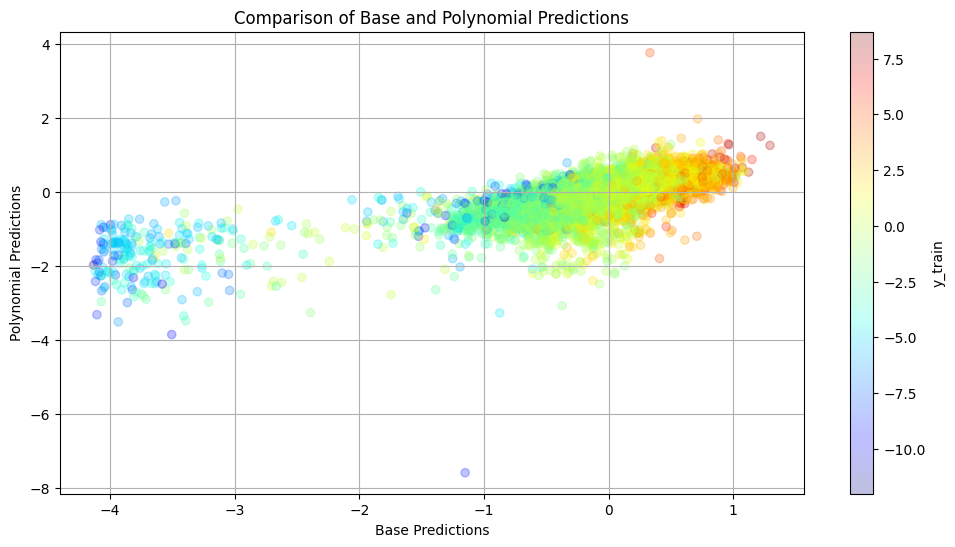

In [15]:
# Compare base predictions against polynomial predictions
plt.figure(figsize=(12, 6))
plt.scatter(
    x=train_preds,
    y=top_features_train['Top_predictions'],
    c=y_train,
    cmap='jet',
    alpha=0.25,
)
plt.xlabel("Base Predictions")
plt.ylabel("Polynomial Predictions")
plt.title("Comparison of Base and Polynomial Predictions")
plt.colorbar(label='y_train')  # Show color scale
plt.grid()
plt.show()

Top features distinguishing hardest vs easiest to predict:
xpass                          | Mean diff: -0.047 | p-value:  4.32e-70
xpass_receivers                | Mean diff: -0.195 | p-value:  5.28e-67
down                           | Mean diff: -0.128 | p-value:  1.95e-41
qb_scramble                    | Mean diff:  0.021 | p-value:  4.18e-36
qb_dropback                    | Mean diff: -0.062 | p-value:  2.32e-35
db_count                       | Mean diff: -0.078 | p-value:  3.39e-22
ydstogo                        | Mean diff: -0.413 | p-value:  2.82e-21
box_minus_rushers              | Mean diff:  0.127 | p-value:  7.67e-21
shotgun                        | Mean diff: -0.046 | p-value:  5.82e-19
defensive_back_density         | Mean diff: -0.024 | p-value:  4.84e-18
Residual Model MSE: 1.847
Residual Model R^2: 0.004


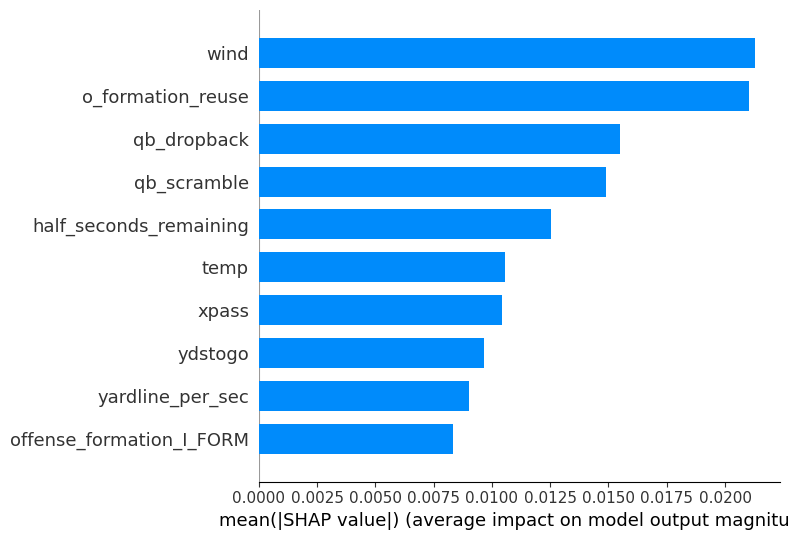

Highest SHAP features: ['wind', 'o_formation_reuse', 'qb_dropback', 'qb_scramble', 'half_seconds_remaining', 'temp', 'xpass', 'ydstogo', 'yardline_per_sec', 'offense_formation_I_FORM', 'xpass_receivers', 'variance_encoder', 'week', 'box_minus_rushers', 'front_density']


In [16]:
# Check index alignment
assert all(train_preds.index == top_features_train.index)
assert all(train_preds.index == y_train.index)

# Average the predictions between base and polynomial
avg_train_preds = (train_preds['base_predictions'] + top_features_train['Top_predictions']) / 2
avg_test_preds = (test_preds['base_predictions'] + top_features_test['Top_predictions']) / 2

# Find residuals between average pred and observed values
train_residuals = y_train - avg_train_preds
test_residuals = y_test - avg_test_preds

# Filter for top 25 percent of predictions
top_33_percentile = train_residuals[train_residuals >= train_residuals.quantile(0.67)]
bottom_33_percentile = train_residuals[train_residuals <= train_residuals.quantile(0.33)]

# Apply masks to training data
X_train_top = X_train.loc[top_33_percentile.index]
X_train_bottom = X_train.loc[bottom_33_percentile.index]

# Compare features
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Only compare numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

feature_diffs = []
for col in numeric_cols:
    top_vals = X_train_top[col].dropna()
    bottom_vals = X_train_bottom[col].dropna()
    mean_diff = top_vals.mean() - bottom_vals.mean()
    t_stat, p_val = ttest_ind(top_vals, bottom_vals, equal_var=False)
    feature_diffs.append((col, mean_diff, p_val))

feature_diffs = sorted(feature_diffs, key=lambda x: x[2])

print("Top features distinguishing hardest vs easiest to predict:")
for col, diff, p in feature_diffs[:10]:
    print(f"{col:30s} | Mean diff: {diff: .3f} | p-value: {p: .3g}")

# Fit xgboost on the residuals
model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.025, max_depth=10, reg_lambda=10.0, gamma=1.0)
train_residuals = pd.DataFrame(train_residuals, columns=['residuals'], index=X_train_scaled.index).fillna(0)
test_residuals = pd.DataFrame(test_residuals, columns=['residuals'], index=X_test_scaled.index).fillna(0)
model.fit(X_train_scaled, train_residuals)
mse = mean_squared_error(test_residuals, model.predict(X_test_scaled))
print(f"Residual Model MSE: {mse:.3f}")
rsquared = r2_score(test_residuals, model.predict(X_test_scaled))
print(f"Residual Model R^2: {rsquared:.3f}")

# Run shap test on residual model
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP values
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=X_test_scaled.columns, plot_type='bar', max_display=10)

# Highest shap values
highest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
num_features_to_show = 15  # Change this to show more features
highest_shap_features = [X_test_scaled.columns[i] for i in highest_shap_indices[:num_features_to_show]]
print("Highest SHAP features:", highest_shap_features)

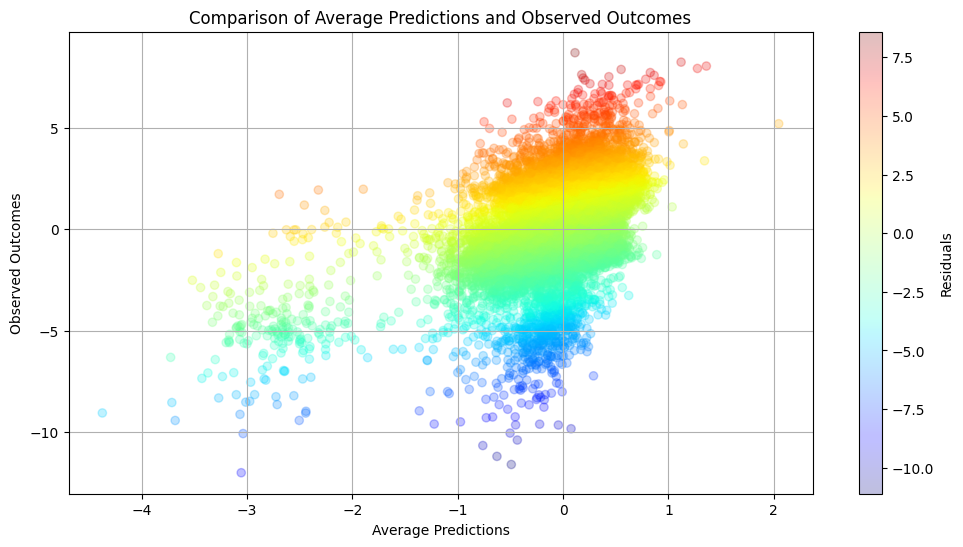

In [17]:
# Compare base predictions against polynomial predictions
# train_residuals = y_train - avg_train_preds
train_residuals = train_residuals.squeeze()
plt.figure(figsize=(12, 6))
plt.scatter(
    x=avg_train_preds,
    y=y_train,
    c=train_residuals,
    cmap='jet',
    alpha=0.25,
)
plt.xlabel("Average Predictions")
plt.ylabel("Observed Outcomes")
plt.title("Comparison of Average Predictions and Observed Outcomes")
plt.colorbar(label='Residuals')  # Show color scale
plt.grid()
plt.show()

# Make & Save Predictions

In [23]:
import nfl_data_py as nfl

# Define the years to import
yrs = range(2015, 2024)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

df, categorical_cols, standard_cols, core_cols, personnel_cols = feature_engineering(pbp_data)

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [27]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Example: your raw features and target
X = df.drop(columns=['epa', 'game_id', 'play_id']).copy()
y = df['epa'].copy()

# Create fold splits
kf = KFold(n_splits=3, shuffle=True, random_state=999)

# Store fold indices for later reuse
folds = []
for train_idx, test_idx in kf.split(X):
    folds.append((train_idx, test_idx))
    
oof_preds = []

for fold_id, (train_idx, test_idx) in enumerate(folds):
    # Keep the original ids for later
    train_ids = df.iloc[train_idx][['game_id', 'play_id', 'epa']]
    test_ids = df.iloc[test_idx][['game_id', 'play_id', 'epa']]

    # Apply scaling only to training set
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Remove infinities and NaNs
    X_train = X_train.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

    # Target encoding
    group_collection = ['down', 'play_type_run', 'defense_coverage_type_COVER_1', 'defense_coverage_type_COVER_0', 'defense_man_zone_type_ZONE_COVERAGE', 'offense_formation_SINGLEBACK', 
                    'offense_formation_SHOTGUN', 'd_coverage_reuse']
    # Build group means on training data only
    group_means = df.iloc[train_idx].groupby(group_collection)['epa'].std().reset_index()
    group_means = group_means.rename(columns={'epa': 'variance_encoder'})

    # Merge into train
    X_train = X_train.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )
    # Merge into test
    X_test = X_test.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )
    # Create a new Series with the correct index for assignment
    variance_encoder_series = pd.concat([
        pd.Series(X_train['variance_encoder'].values, index=train_idx),
        pd.Series(X_test['variance_encoder'].values, index=test_idx)
    ])

    # Assign to df using .loc to align by index
    df['variance_encoder'] = variance_encoder_series
    df['variance_encoder'] = df['variance_encoder'].fillna(0)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for consistency
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    X_train_scaled = X_train_scaled.fillna(0)
    X_test_scaled = X_test_scaled.fillna(0)
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    #X_train_scaled = X_train_scaled.reset_index(drop=True)
    #y_train = y_train.reset_index(drop=True)
    #X_test_scaled = X_test_scaled.reset_index(drop=True)
    #y_test = y_test.reset_index(drop=True)

    # Define testing cols
    cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols

    # Define base predictions
    base_train_preds, base_test_preds, base_model = base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, cols, fold_id, "Base")

    base_test_preds = pd.DataFrame({'Base_predictions': np.ravel(base_test_preds)}, index=test_idx)

    Highest_SHAP_features = ['o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 
                         'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']

    # Use iloc since test_idx is positional, not labels
    test_ids = df.iloc[test_idx][['game_id', 'play_id', 'epa'] + Highest_SHAP_features]
    base_test_preds.index = test_ids.index  # force alignment
    base_test_preds = test_ids.join(base_test_preds)

    oof_preds.append(base_test_preds)

# Combine folds into one OOF dataframe
oof_preds = pd.concat(oof_preds).sort_index()

# Shrink predictions by rsquared
rsquared = r2_score(oof_preds['epa'].fillna(0), oof_preds['Base_predictions'].fillna(0))
oof_preds['shrinked_preds'] = oof_preds['Base_predictions'] * rsquared

# Define residuals
oof_preds['residual_epa'] = oof_preds['epa'] - oof_preds['shrinked_preds']

# Save to C:\Users\Jack\Documents\GitHub\FFInsights
oof_preds.to_csv(r'C:\Users\Jack\Documents\GitHub\FFInsights\context_preds.csv', index=False)

Fold 0 Base Base       Test MSE: 1.800, Test R^2: 0.062 | Train MSE: 1.581, Train R^2: 0.176
Fold 1 Base Base       Test MSE: 1.801, Test R^2: 0.058 | Train MSE: 1.605, Train R^2: 0.164
Fold 2 Base Base       Test MSE: 1.810, Test R^2: 0.058 | Train MSE: 1.598, Train R^2: 0.166


In [21]:
df.columns

Index(['defenders_in_box', 'ydstogo', 'half_seconds_remaining', 'wp', 'ep',
       'week', 'down', 'number_of_pass_rushers', 'yardline_100', 'xpass',
       ...
       'surface_a_turf', 'surface_astroplay', 'surface_astroturf',
       'surface_fieldturf', 'surface_grass', 'surface_grass ',
       'surface_matrixturf', 'surface_sportturf', 'variance_encoder_x',
       'variance_encoder_y'],
      dtype='object', length=107)

In [121]:
oof_preds.describe()

,play_id,epa,Base_predictions,shrinked_preds,residual_epa
count,309149.000000,309148.000000,309149.000000,309149.000000,309148.000000
mean,2097.117676,-0.002919,-0.003241,-0.000193,-0.002726
std,1230.788696,1.384917,0.360245,0.021462,1.379824
min,36.000000,-13.584859,-5.221240,-0.311064,-13.585257
25%,1026.000000,-0.625574,-0.127756,-0.007611,-0.626429
50%,2102.000000,-0.178753,0.011235,0.000669,-0.178017
75%,3135.000000,0.708110,0.166134,0.009898,0.705532
max,5899.000000,8.882384,1.805925,0.107591,8.871137


In [118]:
# merge play_type back to oof_preds
oof_preds = oof_preds.merge(pbp_data[['game_id', 'play_id', 'play_type']], on=['game_id', 'play_id'], how='left')
oof_preds.head(10)

,game_id,play_id,epa,Base_predictions,shrinked_preds,residual_epa,play_type
0,2017_01_ARI_DET,73.0,0.025196,0.052571,0.003806,0.021389,pass
1,2017_01_ARI_DET,97.0,-0.362216,0.022437,0.001625,-0.363841,run
2,2017_01_ARI_DET,118.0,1.880075,-0.372530,-0.026974,1.907048,pass
3,2017_01_ARI_DET,153.0,-0.948572,-0.331560,-0.024007,-0.924565,run
4,2017_01_ARI_DET,174.0,-0.913345,0.111365,0.008064,-0.921409,pass
5,2017_01_ARI_DET,207.0,-4.785328,-0.380542,-0.027554,-4.757775,pass
6,2017_01_ARI_DET,233.0,0.051485,-0.178605,-0.012932,0.064417,run
7,2017_01_ARI_DET,254.0,-11.603202,-0.305249,-0.022102,-11.581100,pass
8,2017_01_ARI_DET,316.0,-0.616428,-0.396459,-0.028706,-0.587722,run
9,2017_01_ARI_DET,337.0,-0.546338,-0.376297,-0.027246,-0.519092,pass


In [ ]:
context_preds = pd.read_csv(r'C:\Users\Jack\Documents\GitHub\FFInsights\context_preds.csv')
context_preds.head(10)

,game_id,play_id,epa,Base_predictions,shrinked_preds,residual_epa
0,2015_01_BAL_DEN,51.0,-0.337139,-0.132337,0.002166,-0.339304
1,2015_01_BAL_DEN,75.0,-0.262481,NaN,NaN,NaN
2,2015_01_BAL_DEN,96.0,1.661242,-0.133492,0.002185,1.659057
3,2015_01_BAL_DEN,120.0,-0.518931,NaN,NaN,NaN
4,2015_01_BAL_DEN,141.0,-0.449598,NaN,NaN,NaN


In [118]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Example: your raw features and target
X = df.drop(columns=['epa', 'game_id', 'play_id']).copy()
y = df['epa'].copy()

# Clip y
#y = y.clip(lower=-1, upper=1)

# Create fold splits
kf = KFold(n_splits=2, shuffle=True, random_state=999)

# Store fold indices for later reuse
folds = []
for train_idx, test_idx in kf.split(X):
    folds.append((train_idx, test_idx))
    
oof_preds = []

for fold_id, (train_idx, test_idx) in enumerate(folds):
    # Apply scaling only to training set
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Remove infinities and NaNs
    X_train = X_train.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

    # Target encoding
    group_collection = ['down', 'play_type_run', 'defense_coverage_type_COVER_1', 'defense_coverage_type_COVER_0', 'defense_man_zone_type_ZONE_COVERAGE', 'offense_formation_SINGLEBACK', 
                    'offense_formation_SHOTGUN']
    # Build group means on training data only
    group_means = df.iloc[train_idx].groupby(group_collection)['epa'].std().reset_index()
    group_means = group_means.rename(columns={'epa': 'variance_encoder'})
    # Merge into train
    X_train = X_train.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )
    # Merge into test
    X_test = X_test.merge(
        group_means, 
        on=group_collection, 
        how='left'
    )

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for consistency
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    X_train_scaled = X_train_scaled.fillna(0)
    X_test_scaled = X_test_scaled.fillna(0)
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    X_train_scaled = X_train_scaled.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_scaled = X_test_scaled.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Define testing cols
    cols = categorical_cols + personnel_cols + core_cols + ['variance_encoder'] + standard_cols

    # Define base predictions
    base_train_preds, base_test_preds, base_model = base_fold_eval(X_train_scaled, X_test_scaled, y_train, y_test, cols, fold_id, "Base")

    # Highest shap values
    import shap
    explainer = shap.TreeExplainer(base_model)
    shap_values = explainer.shap_values(X_test_scaled[cols])
    highest_shap_indices = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
    num_features_to_show = 20
    highest_shap_features = [cols[i] for i in highest_shap_indices[:num_features_to_show]]

    # Apply polynomial ridge to each collection of features
    poly_features_train, poly_features_test = poly_base_top_features(
        X_train_scaled, X_test_scaled, y_train, y_test, highest_shap_features, fold_id, "Poly", top_n=10
    )

    # ----------- COMBINE ALL SELECTED FEATURES ------------
    final_X_train = pd.concat([
        poly_features_train,
        base_train_preds
    ], axis=1)

    final_X_test = pd.concat([
        poly_features_test,
        base_test_preds
    ], axis=1)

    # Remove duplicate columns if any
    final_X_train = final_X_train.loc[:, ~final_X_train.columns.duplicated()]
    final_X_test = final_X_test.loc[:, ~final_X_test.columns.duplicated()]

    # Convert y to DataFrame for consistency
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    y_train = y_train.values.flatten()
    y_test = y_test.values.flatten()

    # Run XGBoost
    import xgboost as xgb
    from sklearn.neural_network import MLPRegressor
    xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.005, max_depth=5, reg_lambda=100000.0, gamma=5.10)
    xgb_model = Ridge(alpha=12000.0)
    xgb_model = MLPRegressor(hidden_layer_sizes=(5, 5), max_iter=1000, alpha=10.01, tol=1)
    xgb_model.fit(final_X_train, y_train)
    fold_oof_preds = xgb_model.predict(final_X_test)
    oof_preds.append(fold_oof_preds)
    mse_xgb = mean_squared_error(y_test, fold_oof_preds)
    r2_xgb = r2_score(y_test, fold_oof_preds)
    train_preds = xgb_model.predict(final_X_train)
    train_mse_xgb = mean_squared_error(y_train, train_preds)
    train_r2_xgb = r2_score(y_train, train_preds)
    print(f"Fold {fold_id} --- FINAL MSE: {mse_xgb:.3f}, R^2: {r2_xgb:.3f} | Train MSE: {train_mse_xgb:.3f}, Train R^2: {train_r2_xgb:.3f}")

Fold 0 Base Base       Test MSE: 1.749, Test R^2: 0.077 | Train MSE: 1.564, Train R^2: 0.181
Fold 0 Poly Polynomial   Test  MSE: 1.762, Test R^2: 0.070 | Train MSE: 1.762, Train R^2: 0.077
Fold 0 --- FINAL MSE: 1.822, R^2: 0.038 | Train MSE: 1.399, Train R^2: 0.267
Fold 1 Base Base       Test MSE: 1.771, Test R^2: 0.072 | Train MSE: 1.557, Train R^2: 0.178
Fold 1 Poly Polynomial   Test  MSE: 1.783, Test R^2: 0.066 | Train MSE: 1.741, Train R^2: 0.081
Fold 1 --- FINAL MSE: 1.831, R^2: 0.041 | Train MSE: 1.414, Train R^2: 0.254


In [ ]:
from sklearn.model_selection import ParameterGrid
import xgboost as xgb

param_grid = {
    'learning_rate': [0.005, 0.05],
    'max_depth': [1, 5],
    'reg_lambda': [100000.0, 1.000],
    'gamma': [0.005, 1.00, 15.0]
}

best_mse = float('inf')
best_r2 = None
best_params = None

for params in ParameterGrid(param_grid):
    model = xgb.XGBRegressor(**params, n_estimators=5000)
    model.fit(final_X_train, y_train)
    preds = model.predict(final_X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"Params: {params} | MSE: {mse:.3f}, R^2: {r2:.3f}")
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_params = params

print(f"Best Params: {best_params} | Best MSE: {best_mse:.3f}, Best R^2: {best_r2:.3f}")

Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 1, 'reg_lambda': 100000.0} | MSE: 1.882, R^2: 0.014
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 1, 'reg_lambda': 1.0} | MSE: 1.955, R^2: -0.024
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 1, 'reg_lambda': 100.0} | MSE: 1.955, R^2: -0.024
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 100000.0} | MSE: 1.914, R^2: -0.003
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 1.0} | MSE: 2.041, R^2: -0.069
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 5, 'reg_lambda': 100.0} | MSE: 2.036, R^2: -0.067
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 20, 'reg_lambda': 100000.0} | MSE: 1.914, R^2: -0.003
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 20, 'reg_lambda': 1.0} | MSE: 2.289, R^2: -0.199
Params: {'gamma': 0.005, 'learning_rate': 0.005, 'max_depth': 20, 'reg_lambda': 100.0} | MSE: 2.139,

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPRegressor

param_grid = {
    'hidden_layer_sizes': [(5, 1), (25, 25)],
    'alpha': [0.30, 5.0],
    'learning_rate_init': [0.0001, 0.005],
    'tol': [10.0, 0.0001]
}

best_mse = float('inf')
best_r2 = None
best_params = None

for params in ParameterGrid(param_grid):
    model = MLPRegressor(**params, random_state=42, max_iter=1000)
    model.fit(final_X_train, y_train.ravel() if hasattr(y_train, "ravel") else y_train)
    preds = model.predict(final_X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"Params: {params} | MSE: {mse:.3f}, R^2: {r2:.3f}")
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_params = params

print(f"Best Params: {best_params} | Best MSE: {best_mse:.3f}, Best R^2: {best_r2:.3f}")

Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.0001, 'tol': 5.0} | MSE: 1.834, R^2: 0.040
Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.0001, 'tol': 0.0001} | MSE: 2.025, R^2: -0.061
Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.005, 'tol': 5.0} | MSE: 1.979, R^2: -0.037
Params: {'alpha': 1.0, 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.005, 'tol': 0.0001} | MSE: 1.985, R^2: -0.040
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.0001, 'tol': 5.0} | MSE: 2.185, R^2: -0.144
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.0001, 'tol': 0.0001} | MSE: 2.009, R^2: -0.052
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.005, 'tol': 5.0} | MSE: 1.996, R^2: -0.045
Params: {'alpha': 1.0, 'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.005, 'tol': 0.0001} | MSE: 2.088, R^2: -0.094
Params: {'alp

In [16]:
def context_forecast(pbp_data, diagnostics=False, pca=False):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures, StandardScaler

    def preprocess_context_features(df, cat_cols, target='epa', pca_enabled=False):
        # Drop plays not relevant
        df = df[df['play_type'].isin(['run', 'pass'])].copy()

        # Step 1: One-hot encode specified categorical columns
        df_cat_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

        # Step 2: Drop string and identifier columns
        exclude_cols = ['game_id', 'play_id', 'epa', 'offense_personnel', 'defense_personnel', 'home_team', 'posteam', 'defteam']
        object_cols = df_cat_encoded.select_dtypes(include=['object']).columns.tolist()
        df_clean = df_cat_encoded.drop(columns=[col for col in object_cols if col in df_cat_encoded.columns] +
                                                [col for col in exclude_cols if col in df_cat_encoded.columns])

        # Step 3: Separate features and labels
        y = df[target].fillna(0).values
        X = df_clean.fillna(0)

        # Step 4: Identify dummy (binary) columns for polynomial interaction
        dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
        X_dummy = X[dummy_cols].copy()
        X_non_dummy = X.drop(columns=dummy_cols)

        # Step 5: Split data BEFORE transformation to avoid leakage
        X_dummy_train, X_dummy_test, X_non_dummy_train, X_non_dummy_test, y_train, y_test = train_test_split(
            X_dummy, X_non_dummy, y, test_size=0.15, random_state=42
        )

        # Step 6: Polynomial expansion (interaction-only) on categorical dummies
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_dummy_train_poly = poly.fit_transform(X_dummy_train)
        X_dummy_test_poly = poly.transform(X_dummy_test)

        poly_cols = poly.get_feature_names_out(X_dummy.columns)

        # Recombine dummy polynomial interactions with non-dummy numeric features
        X_train_full = pd.DataFrame(
            np.hstack([X_dummy_train_poly, X_non_dummy_train.values]),
            columns=list(poly_cols) + list(X_non_dummy.columns),
            index=X_dummy_train.index
        )
        X_test_full = pd.DataFrame(
            np.hstack([X_dummy_test_poly, X_non_dummy_test.values]),
            columns=list(poly_cols) + list(X_non_dummy.columns),
            index=X_dummy_test.index
        )

        # Step 7: Optional PCA
        if pca_enabled:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=5)
            X_train_pca = pca.fit_transform(X_train_full)
            X_test_pca = pca.transform(X_test_full)

            pca_cols = [f'context_pca_{i+1}' for i in range(X_train_pca.shape[1])]
            X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train_full.index)
            X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test_full.index)

            # Concatenate PCA columns to the original feature sets
            X_train_full = pd.concat([X_train_full, X_train_pca_df], axis=1)
            X_test_full = pd.concat([X_test_full, X_test_pca_df], axis=1)

        # Step 8: Standardize features
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_full),
            columns=X_train_full.columns,
            index=X_train_full.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test_full),
            columns=X_test_full.columns,
            index=X_test_full.index
        )

        return X_train_scaled, X_test_scaled, y_train, y_test
    
    # Preprocess context features
    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_context_features(
        df,
        cat_cols=['play_type', 'offense_formation', 'run_gap', 'defense_man_zone_type', 'defense_coverage_type', 'roof', 'surface'], 
        target='epa', 
        pca_enabled=pca
    )

    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error, r2_score

    clip_ranges = np.percentile(np.abs(y_train), [20, 40, 60, 80]).round(2)
    embedding_names = []

    # Initial features
    X_train_iter = X_train_scaled.copy()
    X_test_iter = X_test_scaled.copy()

    importances = []
    feature_names = X_train_iter.columns.tolist()

    for i, clip_val in enumerate(clip_ranges, 1):
        # Clip target
        y_train_clip = np.clip(y_train, -clip_val, clip_val)
        y_test_clip = np.clip(y_test, -clip_val, clip_val)

        # Fit model
        model = XGBRegressor(n_estimators=3000, learning_rate=0.05, max_depth=5, reg_lambda=10.9901, gamma=10.75)
        model.fit(X_train_iter, y_train_clip)

        # Predict
        y_pred_train = model.predict(X_train_iter)
        y_pred_test = model.predict(X_test_iter)

        # Save predictions as new embedding features
        embed_name = f'clipped_target_{i}'
        embedding_names.append(embed_name)

        # Keep new columns as named DataFrames
        X_train_iter[embed_name] = y_pred_train
        X_test_iter[embed_name] = y_pred_test

        # Optionally, print metrics
        mse = mean_squared_error(y_test_clip, y_pred_test)
        r2 = r2_score(y_test_clip, y_pred_test)
        print(f'Iteration {i} (clip ±{clip_val}): MSE= {mse:.4f}, R2= {r2:.4f}')

        # Store feature importance
        importances.append(model.feature_importances_)
    
    # After the loop, convert to DataFrame for easy analysis:
    importances_df = pd.DataFrame(importances, columns=feature_names)
    importances_df.index = [f'clip_{i+1}' for i in range(len(importances))]

    # After loop, X_train_iter and X_test_iter have all embeddings as extra columns
    # You can now fit a final model using these enriched features

    final_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=1, reg_lambda=10.01, gamma=01.0)
    final_model.fit(X_train_iter, y_train)
    final_pred = final_model.predict(X_test_iter)
    print('Final model: ', mean_squared_error(y_test, final_pred), r2_score(y_test, final_pred))

    # Define full X, concatenate trained sets
    X_train_iter = pd.DataFrame(X_train_iter)
    X_test_iter = pd.DataFrame(X_test_iter)
    X_full_scaled = pd.concat([X_train_iter, X_test_iter], axis=0)

    df['context_expected_epa'] = final_model.predict(X_full_scaled)

    # 3. Model the variance: fit a model to squared residuals
    #    Use the same features as before (X_train_scaled, X_test_scaled)
    from xgboost import XGBRegressor
    variance_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, gamma=1)
    variance_model.fit(X_train_iter, (y_train - final_model.predict(X_train_iter))**2)

    # 4. Optionally, add predicted variance to your output DataFrame
    #    (for the full dataset, predict variance for all rows)
    df['predicted_residual_var'] = variance_model.predict(X_full_scaled)

    # Control for R2
    df['context_expected_epa'] *= r2

    # Diagnostics
    if diagnostics:
        residuals = y_test - final_pred

        # Set up plots
        fig, axes = plt.subplots(2, 2, figsize=(14, 7))

        # 1. Feature importance
        feature_names = X_full_scaled.columns.tolist()
        # Use importances from the last iteration (or pick any row from importances_df)
        last_importance = importances_df.iloc[-1].values
        sorted_indices = np.argsort(last_importance)[::-1][:20]
        sns.barplot(
            x=last_importance[sorted_indices],
            y=np.array(feature_names)[sorted_indices],
            ax=axes[0, 0]
        )
        axes[0, 0].set_title('Feature Importance (Last Iteration)')
        axes[0, 0].set_xlabel('Importance')
        axes[0, 0].set_ylabel('Feature')

        # 2. Residuals vs True EPA
        sns.scatterplot(x=y_test, y=residuals, alpha=0.5, ax=axes[0, 1])
        axes[0, 1].axhline(0, color='red', linestyle='--')
        axes[0, 1].set_xlabel('True EPA')
        axes[0, 1].set_ylabel('Residual (True - Predicted)')
        axes[0, 1].set_title('Residuals vs. True EPA')

        # 3. Histogram of residuals
        sns.histplot(residuals, kde=True, ax=axes[1, 0], bins=30)
        axes[1, 0].set_title('Distribution of Residuals')

        # 4. Prediction vs Actual
        sns.scatterplot(x=y_test, y=final_pred, alpha=0.5, ax=axes[1, 1])
        axes[1, 1].plot([-4, 4], [-4, 4], color='red', linestyle='--')
        axes[1, 1].set_xlim([-4, 4])
        axes[1, 1].set_ylim([-4, 4])
        axes[1, 1].set_xlabel('True EPA')
        axes[1, 1].set_ylabel('Predicted EPA')
        axes[1, 1].set_title('Predicted vs. True EPA')

        plt.tight_layout()
        plt.show()

    # Add original EPA and play identifiers
    df['epa'] = pbp_data.loc[df.index, 'epa'].values
    df['game_id'] = pbp_data.loc[df.index, 'game_id'].values
    df['play_id'] = pbp_data.loc[df.index, 'play_id'].values
    df['residual_epa'] = df['epa'] - df['context_expected_epa']

    if pca:
        pca_cols = [col for col in df.columns if col.startswith('context_pca_')]
        return df[['game_id', 'play_id', 'context_expected_epa', 'epa', 'residual_epa', 'predicted_residual_var'] + pca_cols]
    else:
        # Keep only the original context features
        df = df[['game_id', 'play_id', 'epa', 'context_expected_epa', 'residual_epa']]
        return df[['game_id', 'play_id', 'context_expected_epa', 'epa', 'residual_epa', 'predicted_residual_var']]

context_forecast_df = context_forecast(pbp_data, diagnostics=True, pca=False)

UnboundLocalError: cannot access local variable 'df' where it is not associated with a value